Starting episode 1
No vehicles left, terminating simulation.
Episode 1 finished with total reward: 360544.81
Average Highway Flow: 3.59
Average Ramp Queue: 0.32
Average Vehicle Speed: 7.48
Starting episode 2
No vehicles left, terminating simulation.
Episode 2 finished with total reward: 360701.92
Average Highway Flow: 3.63
Average Ramp Queue: 0.32
Average Vehicle Speed: 7.37
Starting episode 3
No vehicles left, terminating simulation.
Episode 3 finished with total reward: 362711.88
Average Highway Flow: 3.68
Average Ramp Queue: 0.33
Average Vehicle Speed: 7.36
Starting episode 4
No vehicles left, terminating simulation.
Episode 4 finished with total reward: 360790.00
Average Highway Flow: 3.56
Average Ramp Queue: 0.32
Average Vehicle Speed: 7.53
Starting episode 5
No vehicles left, terminating simulation.
Episode 5 finished with total reward: 362198.09
Average Highway Flow: 3.58
Average Ramp Queue: 0.32
Average Vehicle Speed: 7.49
Starting episode 6
No vehicles left, terminating simula

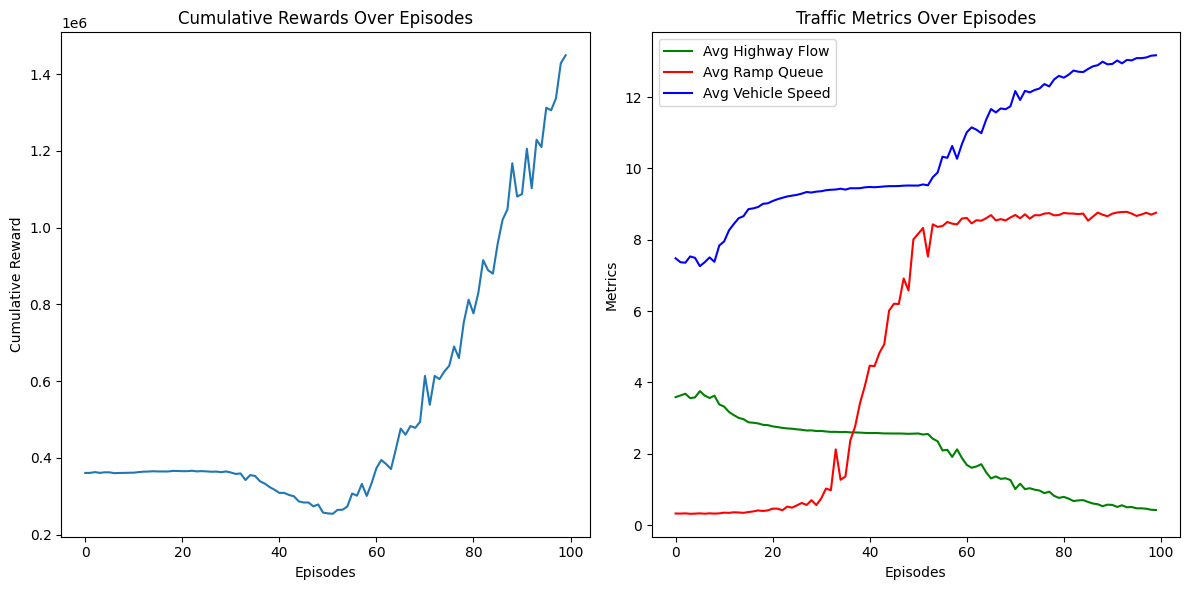

: 

In [ ]:
import traci
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

# Hyperparameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.95  # Discount factor
EPSILON = 1.5  # Initial exploration rate
EPSILON_DECAY = 0.05  # Epsilon decay rate
MIN_EPSILON = 0.001  # Minimum exploration rate
NUM_EPISODES = 100
CONVERGENCE_THRESHOLD = 1e-3
REPLAY_BUFFER_SIZE = 1000
BATCH_SIZE = 32

# Initialize Q-table
num_states_traffic = 11
num_states_queue = 11
num_actions = 3
q_table = np.zeros((num_states_traffic, num_states_queue, num_actions))

# Replay buffer for experience replay
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

# Helper functions
def reset_simulation():
    """Reset the SUMO simulation to the starting point."""
    traci.load(["--net-file", "test1.net.xml", "--route-files", "test1.rou.xml", "--additional-files", "test1.add.xml"])
    return get_state()

def get_state():
    """Retrieve the current state of the system."""
    highway_traffic = min(traci.edge.getLastStepVehicleNumber("E0") / 10, 1)  # Normalize to [0, 1]
    ramp_queue = min(traci.edge.getLastStepVehicleNumber("E2") / 10, 1)  # Normalize to [0, 1]
    traffic_light_phase = traci.trafficlight.getPhase("J1")
    return (highway_traffic, ramp_queue, traffic_light_phase)

def calculate_reward(highway_flow, ramp_queue, vehicle_speed):
    # Constants for the weight of each factor
    highway_flow_weight = 6.4
    ramp_queue_weight = -2
    vehicle_speed_weight = 3.7
    
    # Reward based on the desired behavior
    reward = (highway_flow * highway_flow_weight) + \
            (ramp_queue * ramp_queue_weight) + \
            (vehicle_speed * vehicle_speed_weight)
    
    return reward


def select_action(state, epsilon):
    """Select an action based on the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2])  # Explore: random action
    else:
        state_indices = (int(state[0] * 10), int(state[1] * 10), state[2])
        return np.argmax(q_table[state_indices])  # Exploit: best known action
    
def update_q_values(state, action, reward, next_state, done, alpha=0.1, gamma=0.95):
    """Update the Q-values using the Q-learning formula."""
    
    # Convert state values to indices (assuming state values are between 0 and 1)
    state_indices = (int(state[0] * 10), int(state[1] * 10), state[2])
    next_state_indices = (int(next_state[0] * 10), int(next_state[1] * 10), next_state[2])

    # Get current Q-value from the Q-table
    current_q = q_table[state_indices[0], state_indices[1], action]
    
    # Max Q-value for next state
    max_next_q = np.max(q_table[next_state_indices[0], next_state_indices[1], :])
    
    # Calculate new Q-value
    new_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table
    q_table[state_indices[0], state_indices[1], action] = new_q



def take_action(action):
    """Take the action in the simulation and return the new state, reward, and done flag."""
    traci.trafficlight.setPhase("J1", action)  # Set traffic light phase

    if traci.simulation.getMinExpectedNumber() > 0:  # Check for active vehicles
        traci.simulationStep()
    else:
        print("No vehicles left, terminating simulation.")
        return None, 0, True  # End episode if no vehicles remain

    # Get new state
    next_state = get_state()
    highway_flow = traci.edge.getLastStepVehicleNumber("E0")
    ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
    avg_speed = traci.edge.getLastStepMeanSpeed("E0")  # Average speed on highway
    reward = calculate_reward(highway_flow, ramp_queue, avg_speed)

    done = False
    return next_state, reward, done


def update_q_table(state, action, reward, next_state):
    """Update the Q-table using the Q-learning formula."""
    if next_state is None:
        return

    state_indices = (
        max(0, min(int(state[0] * 10), q_table.shape[0] - 1)),
        max(0, min(int(state[1] * 10), q_table.shape[1] - 1)),
        max(0, min(state[2], q_table.shape[2] - 1))
    )
    next_state_indices = (
        max(0, min(int(next_state[0] * 10), q_table.shape[0] - 1)),
        max(0, min(int(next_state[1] * 10), q_table.shape[1] - 1)),
        max(0, min(next_state[2], q_table.shape[2] - 1))
    )

    max_future_q = np.max(q_table[next_state_indices[0], next_state_indices[1], :])
    current_q = q_table[state_indices[0], state_indices[1], action]
    q_table[state_indices[0], state_indices[1], action] += ALPHA * (reward + GAMMA * max_future_q - current_q)

def replay_experience():
    """Perform experience replay to stabilize learning."""
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = random.sample(replay_buffer, BATCH_SIZE)
    for state, action, reward, next_state in batch:
        update_q_table(state, action, reward, next_state)

# Run simulation
sumo_binary = "sumo"
sumo_config_file = "test1.sumocfg"
traci.start([sumo_binary, "-c", sumo_config_file])

# Run Simulation with Improved Exploration and Exploitation
cumulative_rewards = []
avg_highway_flows = []
avg_ramp_queues = []
vehicle_speeds = []

for episode in range(NUM_EPISODES):
    print(f"Starting episode {episode + 1}")
    total_reward = 0
    state = reset_simulation()
    done = False

    q_table_prev = q_table.copy()  # Copy for convergence check
    episode_highway_flows = []
    episode_ramp_queues = []
    episode_speeds = []

    while not done:
        if state is None:
            done = True
            break

        action = select_action(state, EPSILON)
        next_state, reward, done = take_action(action)
        total_reward += reward

        if next_state is None:
            done = True
            break

        replay_buffer.append((state, action, reward, next_state))
        
        # Use the new update_q_values function instead of update_q_table
        update_q_values(state, action, reward, next_state, done)

        state = next_state

        # Collect average metrics for plotting
        highway_flow = traci.edge.getLastStepVehicleNumber("E0")
        ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
        avg_speed = traci.edge.getLastStepMeanSpeed("E0")  # Vehicle speed
        episode_highway_flows.append(highway_flow)
        episode_ramp_queues.append(ramp_queue)
        episode_speeds.append(avg_speed)

        replay_experience()  # Perform experience replay


    # Log for each episode
    vehicle_speeds.append(np.mean(episode_speeds))
    avg_highway_flows.append(np.mean(episode_highway_flows))
    avg_ramp_queues.append(np.mean(episode_ramp_queues))

    # Print the episode's metrics
    print(f"Episode {episode + 1} finished with total reward: {total_reward:.2f}")
    print(f"Average Highway Flow: {np.mean(episode_highway_flows):.2f}")
    print(f"Average Ramp Queue: {np.mean(episode_ramp_queues):.2f}")
    print(f"Average Vehicle Speed: {np.mean(episode_speeds):.2f}")
    
    # Convergence Check
    max_change = np.max(np.abs(q_table - q_table_prev))
    if max_change < CONVERGENCE_THRESHOLD:
        print(f"Convergence reached at episode {episode + 1} (Q-table change: {max_change:.6f})")
        break

    # Decay Epsilon
    EPSILON = max(MIN_EPSILON, EPSILON * (1 - EPSILON_DECAY))

    cumulative_rewards.append(total_reward)

traci.close()

# Plot Results
plt.figure(figsize=(12, 6))

# Plot Cumulative Rewards
plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")

# Plot Average Highway Flows, Ramp Queues, and Vehicle Speeds
plt.subplot(1, 2, 2)
plt.plot(range(NUM_EPISODES), avg_highway_flows, label="Avg Highway Flow", color="green")
plt.plot(range(NUM_EPISODES), avg_ramp_queues, label="Avg Ramp Queue", color="red")
plt.plot(range(NUM_EPISODES), vehicle_speeds, label="Avg Vehicle Speed", color="blue")
plt.title("Traffic Metrics Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Metrics")
plt.legend()

plt.tight_layout()
plt.show()
